# Statistical Machine Learning - HW2
Adam Ilyas 1002010

## Convolutional Neural Network (CNN)

We will use PyTorch to train a Convolutional Neural Network (CNN) to improve classification
accuracy on the Fashion MNIST dataset. This dataset comprises 50,000 training examples and
10,000 test examples of 28x28-pixel monochrome images of various clothing items. Let us begin by
importing the libraries:

In [1]:
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

There are a total of 10 classes enumerated in the following way:

In [2]:
labels = {
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress', 
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Angle boot'
}

In [3]:
import os
# data
data_path = './data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)

train_dataset = datasets.FashionMNIST(data_path, train=True, 
                                      download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(data_path, train=False, 
                                      download=True, transform=transforms.ToTensor())

In [4]:
print(train_dataset)
print(test_dataset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None
Dataset FashionMNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None


In [5]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True);
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False);

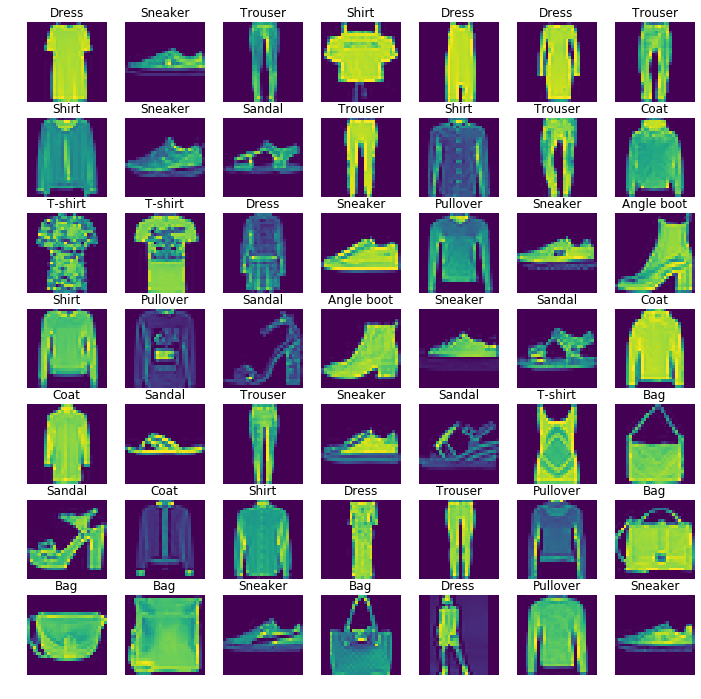

In [6]:
fig = plt.figure(figsize=(12,12));
columns = 7;
rows = 7;
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    
    img_no = numpy.random.randint(len(train_dataset))
    img = train_dataset[img_no][0][0]
    img_class = train_dataset[img_no][1].item()
    label = labels[img_class]
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)
plt.show()

## Batch Normalization:
We will use batch normalization before activation function for each hidden layer<br>
**Input:** Values of $x$ over a minibatch $\mathcal{B}=\left\{x_{1 \ldots m}\right\}$<br>
**Output:** $$\left\{y_{i}=\mathrm{B} \mathrm{N}_{\gamma, \beta}\left(x_{i}\right)\right\}$$
Mini batch mean
$$\mu_{\mathcal{B}} \leftarrow \frac{1}{m} \sum_{i=1}^{m} x$$
mini batch variance
$$\sigma_{\mathcal{B}}^{2} \leftarrow \frac{1}{m} \sum_{i=1}^{m}\left(x_{i}-\mu_{\mathcal{B}}\right)^{2}$$
normalize
$$\widehat{x}_{i} \leftarrow \frac{x_{i}-\mu_{\mathcal{B}}}{\sqrt{\sigma_{\mathcal{B}}^{2}+\epsilon}}$$
scale and shirt
$$y_{i} \leftarrow \gamma \widehat{x}_{i}+\beta \equiv \mathrm{BN}_{\gamma, \beta}\left(x_{i}\right)$$
where $y_{i}$ are the normalized values of the batch

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #initialize the layers 
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, 
                out_channels=16, 
                kernel_size=5, 
                stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=5, 
                stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = nn.Linear(7*7*32, 10)
        
        
    def forward(self, x):
        # invoke the layers
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
    
        return out

In [8]:
def train(model,device,train_loader,optimizer,epoch):
    model.train()
    for batch_idx, (data,target) in enumerate(train_loader):
        data,target = data.to(device),target.to(device)
            
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), 0.001)
        
        # Foward pass
        outputs = model(data)
        loss = criterion(outputs,target)
        
        #Optimizer's step() function is used to update the weights after 
        # backpropogating the gradients
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Epoch:',epoch,',loss:',loss.item())
                     
# defind the variable "pred" which predicts the output and update the variable "correct" 
# to keep track of the no. of correctly classified objects to compute the accuracy of the CNN            
def test(model,device,test_loader, plot=False):
    model.eval()
    correct = 0
    exampleSet = False
    example_data = numpy.zeros([10,28,28])
    example_pred = numpy.zeros(10)
    
    with torch.no_grad():
        for data, target in test_loader:
            data,target = data.to(device), target.to(device)
            
            outputs = model(data)
            _, pred = torch.max(outputs.data,1)
            correct += (pred == target).sum()
            
            if not exampleSet:
                for i in range(10):
                    example_data[i] = data[i][0].to('cpu').numpy()
                    example_pred[i] = pred[i].to('cpu').numpy()
                exampleSet = True
    
    set_accuracy = (100*correct/len(test_loader.dataset)).item()
    print(f'Test set accuracy: {set_accuracy}%')
    
    if plot:
        fig = plt.figure(figsize=(12,6));
        for i in range(10):
            plt.subplot(2,5,i+1)
            plt.imshow(example_data[i],cmap='gray',interpolation='none')
            plt.title(labels[example_pred[i]])
            plt.axis('off')
        plt.show()

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #initialize the layers 
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, 
                out_channels=16, 
                kernel_size=5, 
                stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=5, 
                stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_relu_fc = nn.Sequential(
            nn.Linear(7*7*32, 4096),
            nn.ReLU(),
            nn.Linear(4096, 10)
        )
        
    def forward(self, x):
        # invoke the layers
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc_relu_fc(out)
    
        return out
    
NUM_EPOCHS = 10
LRATE = 0.015

model = CNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=LRATE)

### Xavier initialization
Initizialize weights using
$$w^{(l)} \sim \mathcal{N}\left(0, \sqrt{\frac{2}{n^{(l)}+n^{(l-1)}}}\right)$$
where $n^{(l)}$ is the number of neurons in layer $l$.

This makes the variance of the activations in each layer similar to
one another.

In [18]:
def xavier_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        print(classname)
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.Linear:
        print(classname)
        nn.init.xavier_uniform_(m.weight)
        
        
model.apply(xavier_init)

Conv2d
Conv2d
Linear
Linear


CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_relu_fc): Sequential(
    (0): Linear(in_features=1568, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=10, bias=True)
  )
)

In [19]:
for epoch in range(1,NUM_EPOCHS + 1):
    test(model,device,test_loader)
    train(model,device,train_loader,optimizer,epoch)

Test set accuracy: 9%
Epoch: 1 ,loss: 2.3156614303588867
Epoch: 1 ,loss: 1.2224209308624268
Epoch: 1 ,loss: 0.5392597317695618
Epoch: 1 ,loss: 0.396753191947937
Epoch: 1 ,loss: 0.32061904668807983
Epoch: 1 ,loss: 0.4723408818244934
Test set accuracy: 83%
Epoch: 2 ,loss: 0.3163999915122986
Epoch: 2 ,loss: 0.48356369137763977
Epoch: 2 ,loss: 0.38284480571746826
Epoch: 2 ,loss: 0.4609794318675995
Epoch: 2 ,loss: 0.2221999168395996
Epoch: 2 ,loss: 0.33870720863342285
Test set accuracy: 86%
Epoch: 3 ,loss: 0.48927366733551025
Epoch: 3 ,loss: 0.3791425824165344
Epoch: 3 ,loss: 0.38939765095710754
Epoch: 3 ,loss: 0.25840091705322266
Epoch: 3 ,loss: 0.2831359803676605
Epoch: 3 ,loss: 0.4735012948513031
Test set accuracy: 85%
Epoch: 4 ,loss: 0.36814936995506287
Epoch: 4 ,loss: 0.4937189817428589
Epoch: 4 ,loss: 0.5102061629295349
Epoch: 4 ,loss: 0.4764465093612671
Epoch: 4 ,loss: 0.40978798270225525
Epoch: 4 ,loss: 0.3060723543167114
Test set accuracy: 85%
Epoch: 5 ,loss: 0.30612894892692566
Ep